**Run last cell to install dependancies**

In [844]:
import os
import math
from typing import List
from IPython.utils import io

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.stats import linregress

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML

import fastf1
import requests
import json


time: 5.94 ms (started: 2023-01-03 06:05:11 +00:00)


<h2>Directories</h2>

In [845]:
from google.colab import drive
drive.mount('/content/drive')

# fastf1.Cache.enable_cache('./data/cache') 
# race_dir = './data/Race Data/'
# val_dir = './data/Validation Data/'
# model_path = './data/Pit_Stop_Model.pt'

fastf1.Cache.enable_cache('/content/drive/MyDrive/Capstone/data/cache')  

# dir = '/kaggle/input/formula-1-world-championship-1950-2020/'
race_dir = '/content/drive/MyDrive/Capstone/data/Race Data/'
val_dir = '/content/drive/MyDrive/Capstone/data/Validation Data/'
model_path = '/content/drive/MyDrive/Capstone/data/Pit_Stop_Model.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 649 ms (started: 2023-01-03 06:05:11 +00:00)


<h2>Utilities</h2>

In [846]:
global mmt
mmt = MinMaxScaler()
global mmf
mmf = MinMaxScaler()

pitmap = {}
years = [y for y in range(2012,2023)]
yearmap = {}

time: 1.29 ms (started: 2023-01-03 06:05:12 +00:00)


<h2>General Functions</h2>

In [847]:
#Get Race Data
def get_lap_times():
    lap_times = pd.read_csv(race_dir + 'lap_times.csv')
    return lap_times
def get_pit_stops():
    pit_stops = pd.read_csv(race_dir + 'pit_stops.csv')
    return pit_stops
def get_drivers():
    drivers = pd.read_csv(race_dir + 'drivers.csv')
    return drivers
def get_races():
    races = pd.read_csv(race_dir + 'races.csv')
    return races
def get_circuits():
    circuits = pd.read_csv(race_dir + 'circuits.csv')
    return circuits
def get_qualifying():
    qualifying = pd.read_csv(race_dir + 'qualifying.csv')
    return qualifying
    
def get_laps_left(raceId: int, driverId: str, lap: int) -> int:
    last_lap = lap_times['lap'][(lap_times['raceId'] == raceId) & (lap_times['driverId'] == driverId)].nlargest().iloc[0]
    try:
        stops = pitmap[raceId][driverId]
        stops_num = len(stops.keys())
        stop = 1
        while lap > stops[stop] and stop < stops_num:
            stop += 1
        res = stops[stop] - lap
        if res < 0:
            res = last_lap - lap
    except:
        res = last_lap - lap
    return res

def scale_laps(raceId: int, driverId: str, lap: int) -> int:
    last_lap = lap_times['lap'][(lap_times['raceId'] == raceId) & (lap_times['driverId'] == driverId)].nlargest().iloc[0]
    return lap/last_lap

def map_pits():
    for idx,row in pit_stops.iterrows():
        raceId = row.raceId
        driverId = row.driverId
        stop = row.stop
        lap = row.lap
        if raceId not in pitmap.keys():
            pitmap[raceId] = {}
        if driverId not in pitmap[raceId].keys():
            pitmap[raceId][driverId] = {}
        pitmap[raceId][driverId][stop] = lap

#race:circuit hash map
size = 10
racehash = [{} for h in range(size)]
def get_hash_key(raceId):
    return raceId % size
def hash_raceId(raceId: int(),circuit: str()):
    key = get_hash_key(raceId)
    racehash[key].update({raceId:circuit})
def get_circuit(raceId):
    key = get_hash_key(raceId)
    return racehash[key][raceId]

def map_driver(driverId: int) -> int:
    return drivermap[driverId]

# Data Transformation Functions
def scale_data(data):
    
    data = mmf.fit_transform(data.iloc[:, 4:-1])
    data = Variable(torch.Tensor(data)) 
    data = torch.reshape(data, (data.shape[0], 1, data.shape[1])) 
    return data

def unscale_predicted(predicted):
    # global mmt
    # mmt = MinMaxScaler()
    # predicted = mmt.fit(predicted) ###
    predicted = predicted.data.numpy() 
    predicted = mmt.inverse_transform(predicted)
    predicted = np.round(predicted,0)
    return predicted

def format_target(target):
    
    target = mmt.transform(target.iloc[:, -1:])
    target = Variable(torch.Tensor(target))
    target = target.data.numpy()
    target = mmt.inverse_transform(target)
    return target

def get_projected_pit_lap(data):
    data = data.ravel()
    regress = linregress(np.linspace(0,len(data),len(data)),data)
    slope = regress.slope
    intercept = regress.intercept
    x = (intercept * -1)/slope
    return x.round()


time: 13.2 ms (started: 2023-01-03 06:05:12 +00:00)


In [848]:
lap_times = pd.DataFrame(get_lap_times())
races = pd.DataFrame(get_races())
# races = races.drop(columns = ['url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time','sprint_date','sprint_time'])
circuits = pd.DataFrame(get_circuits())
# qualifying = pd.DataFrame(get_qualifying())
pit_stops = pd.DataFrame(get_pit_stops())
drivers = pd.DataFrame(get_drivers())

time: 147 ms (started: 2023-01-03 06:05:12 +00:00)


In [849]:
for idx,row in races.iterrows():
    yearmap.update({row.raceId:row.year})
    
races = races.loc[races['year'] >= min(years)]
tiremap = {'SUPERSOFT':0,'SOFT':1,'MEDIUM':2,'HARD':3,'INTERMEDIATE':4,'WET':5,'UNKNOWN':6}

time: 24 ms (started: 2023-01-03 06:05:12 +00:00)


In [850]:
for idx,row in races.iterrows():
    hash_raceId(row['raceId'],row['circuitId'])

time: 13.4 ms (started: 2023-01-03 06:05:12 +00:00)


In [851]:
lap_times['circuitId'] = lap_times['raceId'].map(lambda r: get_circuit(int(r)))
lap_times['year'] = lap_times['raceId'].map(yearmap)
lap_times = lap_times.loc[lap_times['year'] >= min(years)]
lap_times

,raceId,driverId,lap,position,time,milliseconds,circuitId,year
0,948,20,1,1,01:36.9,96916,1,2016
1,948,20,2,1,01:31.7,91664,1,2016
2,948,20,3,1,01:32.2,92167,1,2016
3,948,20,4,1,01:32.0,92014,1,2016
4,948,20,5,1,01:32.3,92273,1,2016
...,...,...,...,...,...,...,...,...
156303,1096,822,53,16,01:33.0,92998,24,2022
156304,1096,822,54,16,01:33.0,92995,24,2022
156305,1096,822,55,16,01:31.2,91236,24,2022
156306,1096,822,56,15,01:30.6,90566,24,2022


time: 165 ms (started: 2023-01-03 06:05:12 +00:00)


In [852]:
circuit = 'Silverstone'
year = 2022
driverId = 1

time: 755 µs (started: 2023-01-03 06:05:13 +00:00)


In [853]:
circuitId = circuits.loc[circuits['circuitRef'] == circuit.lower()]
circuitId = circuitId['circuitId'].values[0]
# circuitId

time: 2.67 ms (started: 2023-01-03 06:05:13 +00:00)


In [854]:
pit_stops.loc[(pit_stops['raceId'] == circuitId) & (pit_stops['driverId'] == driverId)]
pit_stops['year'] = pit_stops['raceId'].map(yearmap)
pit_stops = pit_stops.loc[pit_stops['year']>=min(years)]

time: 10.5 ms (started: 2023-01-03 06:05:13 +00:00)


In [855]:
map_pits()

time: 394 ms (started: 2023-01-03 06:05:13 +00:00)


In [856]:
%%capture 
######
race = fastf1.get_session(year, circuit.lower(), 5)
race.load()
df = pd.DataFrame(race.laps)
df.to_csv(f'{race_dir}{circuit}_{year}_Laps.csv')
######
race = pd.read_csv(f'{race_dir}{circuit}_{year}_Laps.csv')
race.LapNumber = race.LapNumber.astype(int)

time: 8.55 s (started: 2023-01-03 06:05:13 +00:00)


In [857]:
%%capture
data = lap_times.loc[(lap_times['circuitId'] == circuitId) & (lap_times['driverId'] == driverId) & (lap_times['year'] == year)]
data['laps_to_pit'] = list(map(get_laps_left, data['raceId'], data['driverId'], data['lap']))
data['total_laps'] = max(data['lap'])

time: 112 ms (started: 2023-01-03 06:05:22 +00:00)


In [858]:
# data.head(10)

time: 449 µs (started: 2023-01-03 06:05:22 +00:00)


In [859]:
# %%capture

#######
drivermap = {}
for idx,row in drivers.iterrows():
    id = row.driverId
    num = row.number
    drivermap.update({id:num})

data['driverNum'] = data['driverId'].map(drivermap)  
compounds = []
for idx,row in data.iterrows():
    dr = row.driverNum
    lap = row.lap
    srow = race.loc[(race['DriverNumber'] == dr) & (race['LapNumber'] == lap)]
    compound = srow.Compound.values[0]
    compounds.append(tiremap[compound])
data = data.assign(compound=compounds)
data = data[['raceId','year','driverId','position','milliseconds','total_laps','lap','compound','laps_to_pit']]
data = data.loc[data['lap'] > 1]
data.to_csv(f'{val_dir}{circuit}_{year}_Test_Data.csv', index=False)


time: 131 ms (started: 2023-01-03 06:05:22 +00:00)


<ipython-input-859-e3e4b058118a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['driverNum'] = data['driverId'].map(drivermap)


In [860]:
data.head(10)

,raceId,year,driverId,position,milliseconds,total_laps,lap,compound,laps_to_pit
142608,1083,2022,1,5,3199557,52,2,2,31
142609,1083,2022,1,6,145614,52,3,2,30
142610,1083,2022,1,6,95270,52,4,2,29
142611,1083,2022,1,6,95120,52,5,2,28
142612,1083,2022,1,4,93731,52,6,2,27
142613,1083,2022,1,4,93955,52,7,2,26
142614,1083,2022,1,4,93679,52,8,2,25
142615,1083,2022,1,4,93704,52,9,2,24
142616,1083,2022,1,4,93338,52,10,2,23
142617,1083,2022,1,4,93335,52,11,2,22


time: 20.3 ms (started: 2023-01-03 06:05:22 +00:00)


# Scale Training Data

In [861]:
# Where to split train/test (percentage)
perc = .8

time: 2.11 ms (started: 2023-01-03 06:05:22 +00:00)


In [862]:

# Define Scalers
# mmf = MinMaxScaler()
# mmt = MinMaxScaler()
# ss = StandardScaler()

# Split features & target
features = data.iloc[:,4:-1]
target = data.iloc[:,-1:]

# Scale features & target
features_scaled = mmf.fit_transform(features)
target_scaled = mmt.fit_transform(target) 

train_lim = math.ceil(features_scaled.shape[0] * perc)

# Split train & test data
features_train = features_scaled[:train_lim, :]
features_test = features_scaled[train_lim:, :]
target_train = target_scaled[:train_lim, :]
target_test = target_scaled[train_lim:, :] 

features_train_tensors = Variable(torch.Tensor(features_train))
features_test_tensors = Variable(torch.Tensor(features_test))

target_train = Variable(torch.Tensor(target_train))
target_test = Variable(torch.Tensor(target_test)) 

train_data = torch.reshape(features_train_tensors,   (features_train_tensors.shape[0], 1, features_train_tensors.shape[1]))
test_data = torch.reshape(features_test_tensors,  (features_test_tensors.shape[0], 1, features_test_tensors.shape[1])) 


time: 35.7 ms (started: 2023-01-03 06:05:22 +00:00)


# Model

In [863]:
class LSTM(nn.Module):
    def __init__(self, num_classes=1, input_size=4, hidden_size=75, num_layers=1):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.lin_1 =  nn.Linear(hidden_size, 300) #original: 128 DELETE ######
        self.lin = nn.Linear(300, num_classes) #original: 128 DELETE ########

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.lin_1(out)
        out = self.relu(out)
        out = self.lin(out)
        return out


    def save(self,model_path):
        torch.save(model.state_dict(), model_path)

    def load(self,model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

time: 3.84 ms (started: 2023-01-03 06:05:22 +00:00)


## Model Training Variables

In [864]:
num_epochs = 20000
learning_rate = 0.0008

train_losses = []

lstm = LSTM()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate) # Original: "Adam" DELETE #######

time: 11.1 ms (started: 2023-01-03 06:05:22 +00:00)


<h2>Train Model</h2>

In [865]:
######################
# Train Model
for epoch in range(num_epochs):
    outputs = lstm.forward(train_data)

    optimizer.zero_grad() 

    loss = criterion(outputs, target_train)
    
    loss.backward() 
    train_losses.append(loss.item())

    optimizer.step() 
    
#     if epoch > 0 and epoch % 5000 == 0:
#         learning_rate *= 1.25
    
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))
 #####################   


Epoch: 0, loss: 0.27560675
Epoch: 1000, loss: 0.00014864
Epoch: 2000, loss: 0.00002116
Epoch: 3000, loss: 0.00000933
Epoch: 4000, loss: 0.00000188
Epoch: 5000, loss: 0.00000015
Epoch: 6000, loss: 0.00000662
Epoch: 7000, loss: 0.00000002
Epoch: 8000, loss: 0.00000002
Epoch: 9000, loss: 0.00000001
Epoch: 10000, loss: 0.00000001
Epoch: 11000, loss: 0.00000003
Epoch: 12000, loss: 0.00000001
Epoch: 13000, loss: 0.00000001
Epoch: 14000, loss: 0.00000001
Epoch: 15000, loss: 0.00000001
Epoch: 16000, loss: 0.00000162
Epoch: 17000, loss: 0.00000001
Epoch: 18000, loss: 0.00000011
Epoch: 19000, loss: 0.00000002
time: 52.5 s (started: 2023-01-03 06:05:22 +00:00)


<h2>Plot Losses</h2>

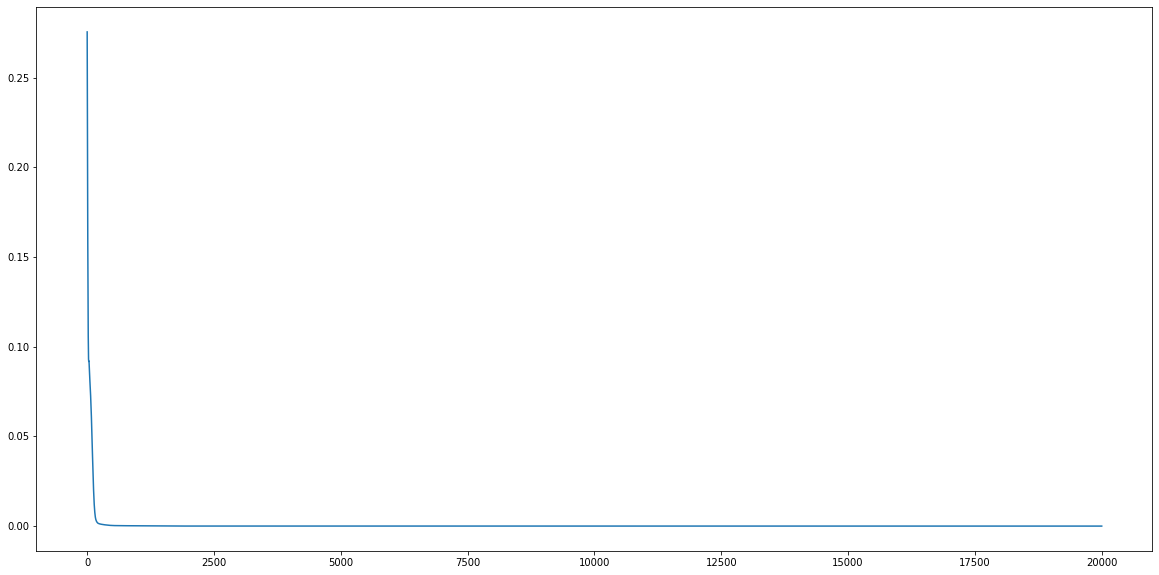

time: 290 ms (started: 2023-01-03 06:06:15 +00:00)


In [866]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int),train_losses)

<h2>Plot prediction</h2>

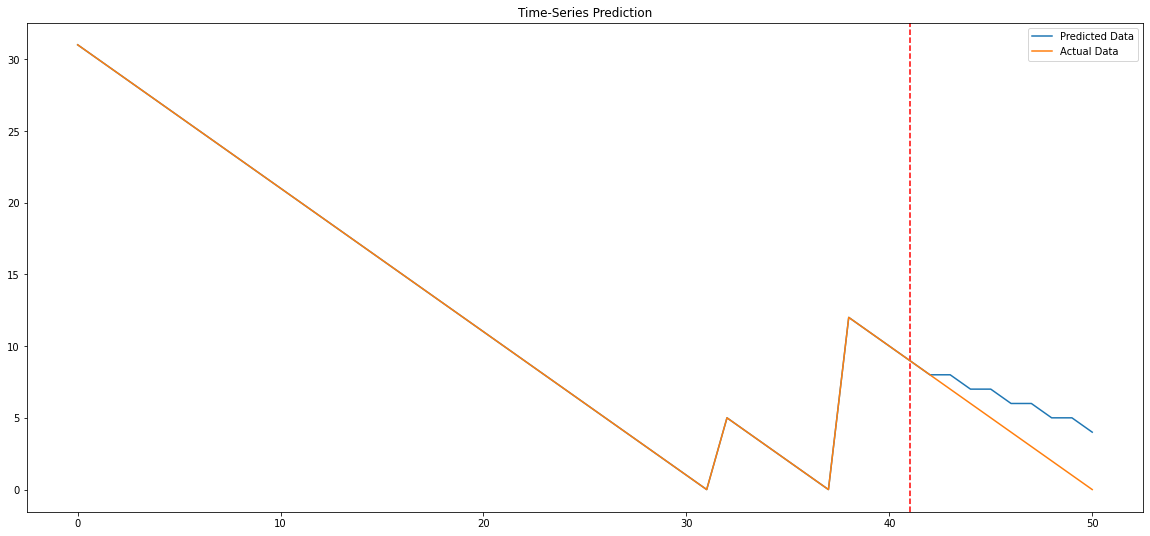

time: 324 ms (started: 2023-01-03 06:06:15 +00:00)


In [867]:
test = scale_data(data)
predicted = lstm(test)
predicted = unscale_predicted(predicted)

target = format_target(data)

plt.figure(figsize=(20,9))
plt.axvline(x=train_lim, c='r', linestyle='--')

plt.plot(predicted, label='Predicted Data')
plt.plot(target, label='Actual Data')
plt.title('Time-Series Prediction')

plt.legend()
plt.show() 

<h2>Model Accuracy</h2>

In [868]:
accuracy = accuracy_score(predicted,target) * 100
print('%.2f' % accuracy + '%')

84.31%
time: 5.49 ms (started: 2023-01-03 06:06:15 +00:00)


<h2>Save Model</h2>

In [698]:
model = lstm
best_model_state = model.state_dict()
torch.save(lstm.state_dict(),model_path)

time: 17.3 ms (started: 2023-01-03 05:16:30 +00:00)


<h1>Test Model</h1>

<h2>Load Trained Model</h2>

In [749]:
model.load(model_path)
model.eval()

LSTM(
  (lstm): LSTM(4, 75, batch_first=True)
  (lin_1): Linear(in_features=75, out_features=300, bias=True)
  (lin): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
)

time: 10.3 ms (started: 2023-01-03 05:42:15 +00:00)


In [869]:
def get_race_data():
    return pd.read_csv(f'{val_dir}{circuit}_{year}_Test_Data.csv')

time: 976 µs (started: 2023-01-03 06:06:33 +00:00)


In [871]:

# print(lap_data.iloc[:,4:-1])
@widgets.interact(lap=(3,len(get_race_data())))
def func(lap=3):
    lap=lap
    race_data = get_race_data()
    
    race_data = race_data.loc[(race_data['lap'] > 1) & (race_data['lap'] <= lap)]
    # print(lap_data)
    # data = lap_data.iloc[:,4:-1]
    # print(lap_data)
    predicted = scale_data(race_data)
    # print(predicted)
    predicted = model(predicted)
    # print(predicted)
    predicted = unscale_predicted(predicted)
    # print(predicted)
    predicted_pit = get_projected_pit_lap(predicted)

    target = format_target(race_data)
    target_pit = get_projected_pit_lap(target)

    print(f'Predicted Pit Stop Lap: {predicted_pit}\nTarget Pit Stop Lap: {target_pit}')
    print('Accuracy: ' + '%2.1f' %  (predicted_pit/target_pit * 100) + '%')

    plt.figure(figsize=(10,5))
    plt.plot(predicted, label = 'Predicted')
    plt.plot(target, label = 'Actual')
    plt.legend()

interactive(children=(IntSlider(value=3, description='lap', max=51, min=3), Output()), _dom_classes=('widget-i…

time: 383 ms (started: 2023-01-03 06:06:42 +00:00)


In [702]:
# def projected_lap(data,lap):
#     lap_data = lap_data.loc[(test_data['lap'] > 1) & (lap_data['lap'] <= lap)]
#     predicted = scale_data(lap_data)
#     predicted = model(predicted)
#     predicted = unscale_predicted(predicted)
#     target = format_target(lap_data)
#     predicted_pit = get_projected_pit_lap(predicted)
#     print(predicted_pit)

time: 581 µs (started: 2023-01-03 05:16:35 +00:00)


In [640]:
# plt.figure(figsize=(20,9))
# plt.plot(predicted, label = 'Predicted')
# plt.plot(target, label = 'Actual')
# plt.legend()

time: 851 µs (started: 2023-01-03 04:54:18 +00:00)


____

___

# Install Dependancies


In [ ]:
!pip install fastf1
!pip install matplotlib==3.1.3
!pip install torchmetrics
!pip install ipython-autotime